In [1]:
from __future__ import division

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)

In [2]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
import agent
import blockworld
import model

In [3]:
from utils import get_data
version = '1.0'
data = get_data(version, '../data')
df = data['blockworld']

Error importing rpy2


In [4]:
def parse_state(state):
    return tuple((tuple(filter(None, col.split(','))) 
                  for col in state.split(':')))

df.states = df.states.apply(lambda states: list(map(parse_state, states)))

Total elapsed for pid 0: 7.0945 minutes
Total elapsed for pid 1: 10.269466666666666 minutes
Total elapsed for pid 2: 5.172866666666667 minutes
Total elapsed for pid 3: 4.303833333333333 minutes


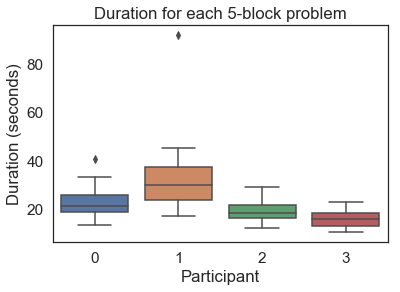

In [5]:
# How long did subjects take?

elapsed_df = []

for pid, pid_df in df.groupby('pid'):
    prev_row_elapsed = 0
    for _, row in pid_df.iterrows():
        elapsed_df.append(dict(
            pid=pid,
            duration_ms=row.time_elapsed - prev_row_elapsed,
            num_blocks=sum(len(col) for col in row.states[0]),
        ))
        prev_row_elapsed = row.time_elapsed

    print(f'Total elapsed for pid {pid}: {prev_row_elapsed/1000/60} minutes')

elapsed_df = pd.DataFrame(elapsed_df)
elapsed_df['duration'] = elapsed_df['duration_ms'] / 1000

sns.boxplot(x='pid', y='duration', data=elapsed_df.loc[elapsed_df.num_blocks == 5])
plt.title('Duration for each 5-block problem')
plt.ylabel('Duration (seconds)')
plt.xlabel('Participant')
None

In [6]:
# Cleaning erroneous data where some states are repeated.
# Totally strange, as we don't permit this in the UI... So we should also prohibit this in logic I think...
# TODO

for row_idx, row in df.iterrows():
    states = row.states

    result = []
    for idx, state in enumerate(states):
        if idx == 0 or state != states[idx-1]:
            result.append(state)
        else:
            print(f'Warning: For row {row_idx} pid {row.pid}, had to exclude repeated state at index {idx}.')

    if len(result) != len(row.states):
        df.at[row_idx, 'states'] = result

In [7]:
actions_col = []
for _, row in df.iterrows():
    actions = [
        blockworld.compute_action_for_state_change(s, s_next)
        for s, s_next in zip(row.states[:-1], row.states[1:])
    ]
    assert len(actions) == len(row.states) - 1
    actions_col.append(actions)
df['actions'] = actions_col

In [8]:
df.head()

,states,time_elapsed,times,trial_type,pid,actions
0,"[((), (C, B), (A,)), ((), (C, B, A), ())]",42447,[2641],blockworld,1,"[(A, 1)]"
1,"[((), (B, D, A), (C,)), ((), (B, D, A, C), ())...",110394,"[8282, 21972, 23209, 24745, 28025, 30305, 3158...",blockworld,1,"[(C, 1), (C, 0), (A, 0), (D, 2), (A, 1), (A, 0..."
2,"[((C,), (A, E, B, D), ()), ((C,), (A, E, B), (...",142769,"[7094, 9246, 12341, 16638, 17918, 19870, 21902...",blockworld,1,"[(D, 2), (C, 2), (B, 2), (E, 2), (A, 0), (E, 1..."
3,"[((E,), (C, B, A), (D,)), ((E,), (C, B), (D, A...",170177,"[7788, 8967, 9646, 11694, 13893, 14972, 16524,...",blockworld,1,"[(A, 2), (B, 2), (C, 2), (E, 1), (C, 0), (B, 0..."
4,"[((E, B), (C, A, D), ()), ((E,), (C, A, D), (B...",215471,"[8210, 9302, 11774, 13726, 17814, 22374, 24937...",blockworld,1,"[(B, 2), (D, 0), (A, 2), (C, 0), (A, 0), (B, 0..."


In [9]:
unique_problems = set([s[0] for s in df.states])
unique_problems_5block = [
    p for p in unique_problems
    if sum(len(col) for col in p) == 5
]
# Sorting so that we can ensure things are more consistent and interpretable across re-runs.
unique_problems_5block = sorted(unique_problems_5block)
# We have 15 problems across all people
len(unique_problems_5block)

15

In [10]:
# Make a filtered df with problem_idx to simplify some things later on

fiveblock = df.copy()
fiveblock['first_state'] = fiveblock.states.apply(lambda s: s[0])
fiveblock = fiveblock[fiveblock.first_state.apply(lambda s: len([block for col in s for block in col])) == 5]
fiveblock['problem_idx'] = fiveblock.first_state.apply(lambda s: unique_problems_5block.index(s))

pid = 1
print('Listing unique 5-block problems and their index.')
for idx, item in enumerate(unique_problems_5block):
    print(idx, item)
print('first five', np.array(unique_problems_5block)[fiveblock[df.pid==pid].problem_idx.values[:5]])
print('should start same as first five here:')
fiveblock[df.pid==pid]

Listing unique 5-block problems and their index.
0 ((), ('C', 'A', 'B'), ('E', 'D'))
1 ((), ('C', 'A', 'E'), ('D', 'B'))
2 (('C',), ('A', 'E', 'B', 'D'), ())
3 (('C',), ('B', 'E', 'D', 'A'), ())
4 (('C', 'E'), ('A', 'B', 'D'), ())
5 (('C', 'E'), ('B', 'A', 'D'), ())
6 (('C', 'E', 'A'), ('B', 'D'), ())
7 (('D', 'A'), ('C', 'B', 'E'), ())
8 (('D', 'B'), ('A', 'E', 'C'), ())
9 (('E',), ('C', 'B', 'A'), ('D',))
10 (('E', 'A'), ('C', 'B'), ('D',))
11 (('E', 'B'), ('C', 'A', 'D'), ())
12 (('E', 'B', 'D'), ('C', 'A'), ())
13 (('E', 'C', 'A'), ('B',), ('D',))
14 (('E', 'D'), ('C', 'A', 'B'), ())
first five [[('C',) ('A', 'E', 'B', 'D') ()]
 [('E',) ('C', 'B', 'A') ('D',)]
 [('E', 'B') ('C', 'A', 'D') ()]
 [('D', 'B') ('A', 'E', 'C') ()]
 [('E', 'A') ('C', 'B') ('D',)]]
should start same as first five here:


/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,states,time_elapsed,times,trial_type,pid,actions,first_state,problem_idx
2,"[((C,), (A, E, B, D), ()), ((C,), (A, E, B), (...",142769,"[7094, 9246, 12341, 16638, 17918, 19870, 21902...",blockworld,1,"[(D, 2), (C, 2), (B, 2), (E, 2), (A, 0), (E, 1...","((C,), (A, E, B, D), ())",2
3,"[((E,), (C, B, A), (D,)), ((E,), (C, B), (D, A...",170177,"[7788, 8967, 9646, 11694, 13893, 14972, 16524,...",blockworld,1,"[(A, 2), (B, 2), (C, 2), (E, 1), (C, 0), (B, 0...","((E,), (C, B, A), (D,))",9
4,"[((E, B), (C, A, D), ()), ((E,), (C, A, D), (B...",215471,"[8210, 9302, 11774, 13726, 17814, 22374, 24937...",blockworld,1,"[(B, 2), (D, 0), (A, 2), (C, 0), (A, 0), (B, 0...","((E, B), (C, A, D), ())",11
5,"[((D, B), (A, E, C), ()), ((D, B, C), (A, E), ...",253361,"[5625, 7687, 10001, 11280, 13344, 17098, 18385...",blockworld,1,"[(C, 0), (E, 2), (C, 1), (B, 1), (D, 2), (B, 2...","((D, B), (A, E, C), ())",8
6,"[((E, A), (C, B), (D,)), ((E,), (C, B), (D, A)...",292643,"[5159, 8151, 11223, 13738, 14840, 16159, 19078...",blockworld,1,"[(A, 2), (A, 1), (D, 0), (A, 0), (B, 0), (C, 0...","((E, A), (C, B), (D,))",10
7,"[((E, D), (C, A, B), ()), ((E, D, B), (C, A), ...",314577,"[5565, 7782, 8518, 10686, 12053, 13390, 14798,...",blockworld,1,"[(B, 0), (A, 2), (C, 2), (B, 2), (D, 2), (E, 1...","((E, D), (C, A, B), ())",14
8,"[((C, E), (A, B, D), ()), ((C, E, D), (A, B), ...",340464,"[3807, 4776, 5982, 7863, 9127, 10729, 13007, 1...",blockworld,1,"[(D, 0), (B, 0), (A, 2), (B, 2), (D, 2), (E, 1...","((C, E), (A, B, D), ())",4
9,"[((C, E), (B, A, D), ()), ((C, E, D), (B, A), ...",359001,"[3656, 6633, 7633, 9394, 10336, 12313, 14352, ...",blockworld,1,"[(D, 0), (A, 2), (B, 2), (D, 2), (E, 1), (D, 1...","((C, E), (B, A, D), ())",5
10,"[((E, C, A), (B,), (D,)), ((E, C, A), (), (D, ...",392464,"[4152, 7783, 10719, 12687, 15352, 16214, 17311...",blockworld,1,"[(B, 2), (A, 2), (C, 2), (E, 1), (C, 0), (A, 0...","((E, C, A), (B,), (D,))",13
11,"[((C, E, A), (B, D), ()), ((C, E, A), (B,), (D...",429577,"[4855, 5917, 8566, 9950, 12171, 15411, 17203, ...",blockworld,1,"[(D, 2), (B, 0), (B, 2), (A, 2), (E, 1), (A, 0...","((C, E, A), (B, D), ())",6


In [11]:
goals_with_clearing = model.make_goals(unique_problems_5block[0])

In [14]:
from functools import lru_cache

# We compute the probability that each agent would take the action the participant took.

def probability_of_actions_for_agent(row, get_actions_fn, uniform_action_selection=True):
    p_action = np.zeros((len(row.actions),))

    for action_idx, (state, participant_action) in enumerate(zip(row.states[:-1], row.actions)):
        p_action[action_idx] = model.probability_of_action(
            state, participant_action, get_actions_fn,
            uniform_action_selection=uniform_action_selection)
    return p_action

# We want to know: what is the probability that the agent would make that move from that state?
# A simplifying case for now: Let's see if there's non-zero probability that the agent will make
# the same move as the participant.

agents = [
    ('optimal', lambda s: model.get_actions(s)),
]

percent_optimal_moves = np.zeros((len(unique_problems_5block), len(df.pid.unique())))

for agent_idx, (agent_name, get_actions_fn) in enumerate(agents):
    # HACK it's good that we pick one problem and agent to solve for all people to exploit overlap in their states
    for problem_idx, initial in enumerate(tqdm(unique_problems_5block)):
        filt = df[df.states.apply(lambda s: s[0] == initial)]
        for _, row in filt.iterrows():
            p_actions = probability_of_actions_for_agent(row, get_actions_fn)
            percent_optimal_moves[problem_idx, row.pid] = np.sum(p_actions > 0, axis=0) / p_actions.shape[0]

percent_optimal_moves

array([[0.9       , 0.9       , 1.        , 0.75      ],
       [0.9       , 0.75      , 0.81818182, 0.71428571],
       [0.81818182, 0.83333333, 0.76923077, 0.90909091],
       [0.90909091, 0.69230769, 1.        , 0.75      ],
       [0.76923077, 0.84615385, 0.76923077, 0.90909091],
       [0.625     , 1.        , 1.        , 0.71428571],
       [0.6       , 0.71428571, 1.        , 0.625     ],
       [0.73333333, 0.84615385, 1.        , 0.63157895],
       [0.81818182, 0.64705882, 0.75      , 0.81818182],
       [0.58823529, 0.76923077, 1.        , 0.78571429],
       [0.64705882, 0.58823529, 0.90909091, 0.625     ],
       [0.66666667, 0.63157895, 0.71428571, 0.75      ],
       [1.        , 0.76923077, 0.90909091, 0.81818182],
       [0.70588235, 0.78571429, 0.83333333, 0.71428571],
       [0.75      , 0.81818182, 0.9       , 0.90909091]])

/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


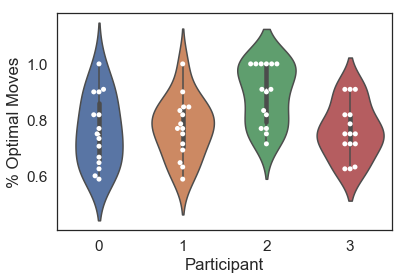

In [15]:
subject_df = pd.DataFrame([
    dict(problem=problem, pid=pid, percent=percent_optimal_moves[problem, pid])
    for problem, pid in np.ndindex(*percent_optimal_moves.shape)
])

f, ax = plt.subplots()
sns.violinplot(x='pid', y='percent', data=subject_df, ax=ax)
sns.swarmplot(x='pid', y='percent', data=subject_df, color='white', ax=ax)

ax.set_ylabel('% Optimal Moves')
ax.set_xlabel('Participant')

None

model_p.shape (12,) rand_p.shape (12,)
p_err.shape (50, 1) logp.shape (50, 12) total_logp.shape (50,)
MLE error prob: {'p_err': 0.32653061224489793, 'logp': -10.523567121978845}


/Users/carlos/pu/multigoals/analysis/model.py:23: RuntimeWarning: divide by zero encountered in log
  logp = np.log(noisy_model_p(p_err))


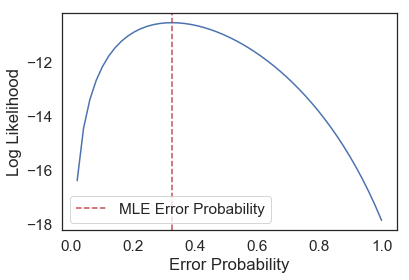

In [16]:
# Fit epsilon-greedy model

agent_idx = 0
problem = blockworld.Blockworld(row.states[0], goals_with_clearing)
model_p = p_actions
rand_p = np.array([1/len(problem.actions(s)) for s in row.states[:-1]])
print('model_p.shape', model_p.shape, 'rand_p.shape', rand_p.shape)
print('MLE error prob:', model.fit_epsilon_greedy_model(model_p, rand_p, debug=True))

In [33]:
agents = [
    (f'k={k}', dict(k=k))
    for k in [1, 2, 3, 4, 5]
] + [
    (f'd={d}', dict(depth_limit=d))
    for d in range(1, 10)
] + [
    ('k=1,d=4', dict(k=1, depth_limit=4)),
    ('k=2,d=4', dict(k=2, depth_limit=4)),
    ('k=2,d=6', dict(k=2, depth_limit=6)),
    ('k=4,d=6', dict(k=4, depth_limit=6)),
    ('k=4,d=8', dict(k=4, depth_limit=8)),
]

In [211]:
p_err = np.zeros((len(unique_problems_5block), len(df.pid.unique()), len(agents)))
logp = np.zeros((len(unique_problems_5block), len(df.pid.unique()), len(agents)))

# dict mapping (PID, agent_idx) to list of (initial state, p_actions (size # actions), rand_p (size # actions))
subject_actions_p = {}

# HACK it's good that we pick one problem and agent to solve for all people to exploit overlap in their states
# HACK or maybe it doesn't matter too much? depends on cache size I think
for problem_idx, initial in enumerate(tqdm(unique_problems_5block)):
    problem_rows = df.states.apply(lambda s: s[0] == initial)
    for _, row in df.loc[problem_rows].iterrows():
        for agent_idx, (agent_name, get_actions_kwargs) in enumerate(agents):
            get_actions_fn = lambda s: model.get_actions(s, **get_actions_kwargs)
            if agent_name == 'geom':
                p_actions = [model.geom_k_likelihood]
            else:
                p_actions = probability_of_actions_for_agent(row, get_actions_fn, uniform_action_selection=True)
            rand_p = np.array([1/len(problem.actions(s)) for s in row.states[:-1]])
            subject_actions_p.setdefault((row.pid, agent_idx), []).append((initial, p_actions, rand_p))
            fit = fit_p_err(p_actions, rand_p, debug=False)
            p_err[problem_idx, row.pid, agent_idx] = fit['p_err']
            logp[problem_idx, row.pid, agent_idx] = fit['logp']

None

/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


KeyboardInterrupt: 

p_actions.shape (162,) rand_p.shape (162,)
p_err.shape (50, 1) logp.shape (50, 162) total_logp.shape (50,)


/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


{'p_err': 0.16326530612244897, 'logp': -93.15569207209762}

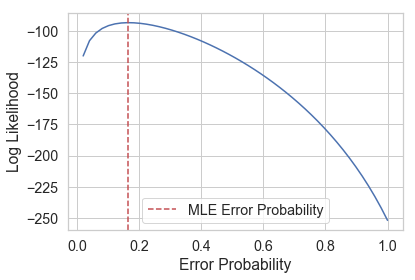

In [52]:
# Testing out code to fit p(error) for one participant across all actions

pid = 2 ; agent_idx = 2

results = subject_actions_p[pid, agent_idx]
p_actions = np.concatenate([p_actions for _, p_actions, rand_p in results], axis=0)
rand_p = np.concatenate([rand_p for _, p_actions, rand_p in results], axis=0)
assert p_actions.shape[0] == rand_p.shape[0]
print('p_actions.shape', p_actions.shape, 'rand_p.shape', rand_p.shape)
fit_p_err(p_actions, rand_p, debug=True)

In [53]:
# dict mapping (PID, agent name) to result of fit_p_err()
subject_p_err = {}

# Now we fit P(error) for each subject, for each agent across all actions
for (pid, agent_idx), results in tqdm(subject_actions_p.items()):
    agent_name, _ = agents[agent_idx]
    p_actions = np.concatenate([p_actions for _, p_actions, rand_p in results], axis=0)
    rand_p = np.concatenate([rand_p for _, p_actions, rand_p in results], axis=0)
    subject_p_err[pid, agent_name] = fit_p_err(p_actions, rand_p, debug=False)

/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


(15, 4, 14)
(4, 14)


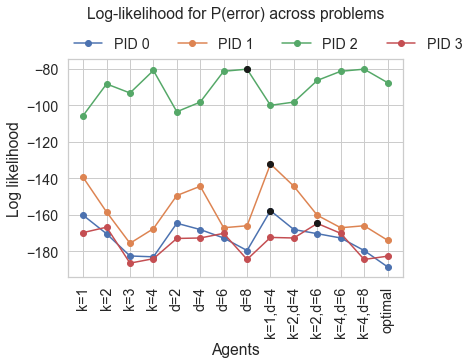

In [59]:
sns.set_style("whitegrid")
f, ax = plt.subplots()

print(logp.shape)
ll = np.sum(logp, axis=0)
print(ll.shape)

names = [name for name, _ in agents]
for pid in sorted(df.pid.unique()):
    ll = [subject_p_err[pid, name]['logp'] for name in names]
    ax.plot(names, ll, '-o', label=f'PID {pid}')
    max_agent = np.argmax(ll)
    max_dot = ax.plot(names[max_agent], ll[max_agent], 'o', c='k')

#ax.legend()
ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=4, 
            borderaxespad=0, frameon=False)

ax.set_title('Log-likelihood for P(error) across problems\n\n')
ax.set_xlabel('Agents')
ax.set_ylabel('Log likelihood')
for tick in ax.get_xticklabels():
    tick.set_rotation(90)


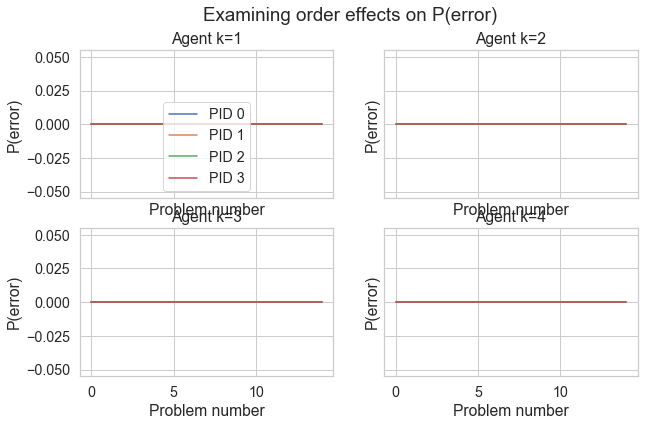

In [194]:
# looking at order effects

f, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)

f.suptitle('Examining order effects on P(error)')

for pid in sorted(fiveblock.pid.unique()):
    p_df = fiveblock.loc[fiveblock.pid == pid]
    for agent_idx, ((name, _), ax) in enumerate(zip(agents, axes.flat)):
        p_err_seq = p_err[p_df.problem_idx, pid, agent_idx]
        ax.plot(p_err_seq, label=f'PID {pid}')

for agent_idx, ((name, _), ax) in enumerate(zip(agents, axes.flat)):
    ax.set_title(f'Agent {name}')
    ax.set_ylabel('P(error)')
    ax.set_xlabel('Problem number')

ax = next(axes.flat)
ax.legend()

None

In [220]:
import random

def generate_actions(state, k=None, depth_limit=None, p=None, p_err=0):
    '''
    Generate actions for agents. We assume that agents replan after each action.

    Can plan with depth limits, k limits (fixed, or with geometric distribution), and take noisy actions as well.
    '''
    problem = blockworld.Blockworld(state, model.make_goals(state))
    if k is None:
        k = len(problem.goals)
    if p is not None:
        k_dist = geom(p)

    actions = []
    states = [state]

    while not problem.goal_test(state):
        if random.uniform(0, 1) < p_err:
            # Take random action
            action = random.choice(problem.actions(state))
            state = problem.result(state, action)
        else:
            if p is not None:
                k = k_dist.rvs()
            next_goal, goal_test, h = agent.make_ordered_k_goal_cost_heuristic(problem, state, k=k, debug=False)
            planned_actions, planned_states = agent.A_Star(
                problem,
                h,
                start=state,
                goal_test=goal_test,
                depth_limit=depth_limit,
                shuffle=True)
            action = planned_actions[0]
            state = planned_states[1]
        actions.append(action)
        states.append(state)

    return actions, states

# Fiddling with toy problem. optimal is 5 move solutions.
initial = ((), ('D', 'A'), ('C', 'B'))
print('k=1', [len(generate_actions(initial, k=1)[0]) for _ in range(10)])
print('k=2 (optimal)', [len(generate_actions(initial, k=2)[0]) for _ in range(10)])
print('k=4 (optimal)', [len(generate_actions(initial, k=4)[0]) for _ in range(10)])
print('k=2 p_err', [len(generate_actions(initial, k=2, p_err=0.2)[0]) for _ in range(10)])
print('geom p=0.8', [len(generate_actions(initial, p=0.8)[0]) for _ in range(10)])

k=1 [6, 6, 6, 6, 6, 6, 6, 6, 5, 6]
k=2 (optimal) [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
k=4 (optimal) [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
k=2 p_err [7, 9, 5, 5, 8, 5, 5, 8, 5, 10]
geom p=0.8 [6, 6, 6, 6, 6, 5, 6, 6, 5, 5]


In [229]:
# parameter recovery: generate a dataset.

import random
random.seed(1338)

generated_df = dict(pid=[], states=[], actions=[])

letters = [chr(ord('a')+i) for i in range(5)]
# Set letter to empty string to jointly optimize
#letters = ['' for i in range(5)]


generating_agents = [
    (f'k=1{l}', dict(k=1)) for l in letters
] + [
    (f'k=2{l}', dict(k=2)) for l in letters
] + [
    (f'k=3{l}', dict(k=3)) for l in letters
] + [
    (f'k=4{l}', dict(k=4)) for l in letters
] + [
    (f'k=2{l} p_err', dict(k=2, p_err=0.2)) for l in letters
] + [
    (f'p=0.6 {l}', dict(p=0.6)) for l in letters
] + [
    (f'p=0.3 {l}', dict(p=0.3)) for l in letters
]

for agent_name, agent_kwargs in generating_agents:
    for initial in unique_problems_5block:
#    hi = (('E', 'C'), ('A', 'B'), ('D',)) 
#    for initial in [hi]:
        '''
        problem = blockworld.Blockworld(initial, make_goals(initial))
        history, completed = agent.solve_using_ordered_goal_subset_astar(
            problem, debug=False, shuffle=True, **agent_kwargs)
        states = [s for a, s in history]
        actions = [a for a, s in history if a is not None]
        '''
        actions, states = generate_actions(initial, **agent_kwargs)
        assert len(actions) == len(states) - 1
        generated_df['states'].append(states)
        generated_df['actions'].append(actions)
        generated_df['pid'].append(agent_name)

generated_df = pd.DataFrame(generated_df)
generated_df.shape

(525, 3)

In [34]:
# parameter recovery: find p(action) for agents to this dataset

def _make_model_inputs(df):
    curr_df = df.copy()
    curr_df['initial_state'] = curr_df['states'].apply(lambda s: s[0])

    # Some code for error likelihood. Assumes all states have same goals/# blocks
    arbitrary_state = curr_df['initial_state'].values[0]
    arbitrary_problem = blockworld.Blockworld(arbitrary_state, model.make_goals(arbitrary_state))
    def _err_likelihood(state, action):
        # HACK should we first check to see if action is even in there??
        return 1/len(arbitrary_problem.actions(state))

    # Indexed by (pid, initial state). Contains dict with
    # - model_p: (size # agents X # actions) and
    # - rand_p: (size # actions)
    subject_p = {
        (row.pid, row.initial_state): dict(
            model_p=np.zeros((len(agents), len(row.actions))),
            rand_p=np.zeros((len(row.actions),)),
        )
        for _, row in curr_df.iterrows()
    }

    # Modeling. We ensure innermost loop is over the same problem to best exploit LRU cache.
    # innermost loop with different problems or different agents would make it hard to cache
    # shared moves between participants.
    # This is ultimately why we structure data flow in this function in such a particular way.
    # HACK HACK however not clear that perf is really that impacted....
    for agent_idx, (agent_name, get_actions_kwargs) in enumerate(tqdm(agents)):
        get_actions_fn = lambda s: model.get_actions(s, **get_actions_kwargs)
        for _, rows in curr_df.groupby('initial_state'):
            for _, row in rows.iterrows():
                # Find or create our appropriate state
                subject_action_p = subject_p[row.pid, row.initial_state]
                for action_idx, (state, participant_action) in enumerate(zip(row.states[:-1], row.actions)):
                    subject_action_p['model_p'][agent_idx, action_idx] = model.probability_of_action(
                        state, participant_action, get_actions_fn,
                        uniform_action_selection=True)
                    subject_action_p['rand_p'][action_idx] = _err_likelihood(state, participant_action)

    # Now we make big matrices of model_p and rand_p for each subject
    model_inputs = {}
    for pid in curr_df['pid'].unique():
        m = []
        r = []
        # assumes every pid did every problem
        for initial_state in curr_df['initial_state'].unique():
            m.append(subject_p[pid, initial_state]['model_p'])
            r.append(subject_p[pid, initial_state]['rand_p'])
        model_inputs[pid] = dict(
            model_p=np.concatenate(m, axis=-1),
            rand_p=np.concatenate(r),
        )
    return model_inputs

model_inputs = _make_model_inputs(fiveblock)

In [35]:
# Now fitting model

from scipy.optimize import minimize
from scipy.stats.distributions import geom
import re

def _fit_models(problem, agent_names, action_lk, rand_p):
    # Values of k to test. Right now we simplify by assuming all problems have same # of goals
    max_k = len(problem.goals)
    ks = np.arange(1, max_k+1)

    # Find indexes of k-agents in action_lk
    k_agent_idxs = [agent_names.index(f'k={k}') for k in ks]
    k_action_lk = action_lk[k_agent_idxs, :]

    # Values of d to test. We pick max value from agents
    dmatches = [re.match(r'^d=(\d+)$', agent_name) for agent_name in agent_names]
    max_d = max([int(m.group(1)) for m in dmatches if m])
    ds = np.arange(1, max_d+1)

    # Find indexes of d-agents in action_lk
    d_agent_idxs = [agent_names.index(f'd={d}') for d in ds]
    d_action_lk = action_lk[d_agent_idxs, :]

    # Make sure shapes are good
    assert len(rand_p.shape) == 1
    assert action_lk.shape == (len(agent_names), len(rand_p))

    def _neg_ll(params):
        p, p_err = params
        # HACK for some reason this fn can get called by minimize() with an out of bounds value.
        p = max(min(p, 1), 0)
        p_err = max(min(p_err, 1), 0)

        # Set up geometric distribution over k
        pk = geom(p).pmf(ks)
        pk[-1] = 1 - pk[:-1].sum()  # tail probability of all k >= max_k

        # Determine model_p given this distribution over k
        model_p = pk.dot(k_action_lk)
        assert model_p.shape == rand_p.shape

        # Determine prob given prob of noise
        noisy_p = (1 - p_err) * model_p + p_err * rand_p

        return -np.log(noisy_p).sum()

    def _neg_ll_depth(params):
        # HACK HACK HACK copied from above...........
        p, p_err = params
        # HACK for some reason this fn can get called by minimize() with an out of bounds value.
        p = max(min(p, 1), 0)
        p_err = max(min(p_err, 1), 0)

        # Set up geometric distribution over d
        pd = geom(p).pmf(ds)
        pd[-1] = 1 - pd[:-1].sum()  # tail probability of all d >= max_d

        # Determine model_p given this distribution over d
        model_p = pd.dot(d_action_lk)
        assert model_p.shape == rand_p.shape

        # Determine prob given prob of noise
        noisy_p = (1 - p_err) * model_p + p_err * rand_p

        return -np.log(noisy_p).sum()

    def _neg_ll_noise(params, model_p):
        p_err, = params
        p_err = max(min(p_err, 1), 0)

        # Determine prob given prob of noise
        noisy_p = (1 - p_err) * model_p + p_err * rand_p

        #print('_neg_ll_noise', p_err, -np.log(noisy_p).sum())
        return -np.log(noisy_p).sum()

    out = {}

    # Trying to avoid issues when model_p can be 0
    safe_bounds = [1e-08, 1-1e-08]

    #for kidx, k in enumerate(ks):
    for agent_idx, agent_name in enumerate(agent_names):
        # Find model_p for this k
        model_p = action_lk[agent_idx, :]
        res = minimize(
            _neg_ll_noise, np.array([0.5]), bounds=[safe_bounds],
            args=(model_p,), method='L-BFGS-B',
        )
        assert res.success, f'Model fitting failed. {res}'
        out[agent_name] = dict(p_err=res.x[0], logp=-res.fun)#, optres=res)

    res = minimize(_neg_ll, np.array([0.5, 0.5]), bounds=[safe_bounds, safe_bounds], method='L-BFGS-B')
    assert res.success, f'Model fitting failed. {res}'
    p, p_err = res.x
    out['geom'] = dict(p=p, p_err=p_err, logp=-res.fun)#, optres=res)

    res = minimize(_neg_ll_depth, np.array([0.5, 0.5]), bounds=[safe_bounds, safe_bounds], method='L-BFGS-B')
    assert res.success, f'Model fitting failed. {res}'
    p, p_err = res.x
    out['geom_depth'] = dict(p=p, p_err=p_err, logp=-res.fun)#, optres=res)

    return out

agent_names = [name for name, _ in agents]

In [37]:
# Comparing new model fits to old

pid = list(model_inputs.keys())[1]#'k=2a'
print('pid', pid)
arbitrary_state = fiveblock['states'].values[0][0]
arbitrary_problem = blockworld.Blockworld(arbitrary_state, model.make_goals(arbitrary_state))
i = model_inputs[pid]
fits = _fit_models(arbitrary_problem, agent_names, i['model_p'], i['rand_p'])
for k, fit in fits.items():
    print(k, fit)
print()
# Now sanity checking against old code...
for agent_idx in [agent_names.index(f'k={k}') for k in range(1, 6)]:
    name, _ = agents[agent_idx]
    print(name, model.fit_epsilon_greedy_model(i['model_p'][agent_idx, :], i['rand_p']))

pid 2
k=1 {'p_err': 0.15862808089545782, 'logp': -105.49447016029579}
k=2 {'p_err': 0.13115511547682268, 'logp': -88.16186242543245}
k=3 {'p_err': 0.16652982100765062, 'logp': -93.15099950392302}
k=4 {'p_err': 0.1351536736032826, 'logp': -80.77357969452635}
k=5 {'p_err': 0.15740219684385118, 'logp': -87.4669398105386}
d=1 {'p_err': 1e-08, 'logp': -132.78511432822046}
d=2 {'p_err': 0.012381701716337831, 'logp': -103.27897907790923}
d=3 {'p_err': 0.04189327647063278, 'logp': -90.41402064825404}
d=4 {'p_err': 0.1085999287173137, 'logp': -98.11593466900015}
d=5 {'p_err': 0.09530011850646715, 'logp': -86.27457788135024}
d=6 {'p_err': 0.1094590628668003, 'logp': -81.22794665735574}
d=7 {'p_err': 0.15990695416006892, 'logp': -91.70031041584755}
d=8 {'p_err': 0.12878913425356137, 'logp': -80.0822072362661}
d=9 {'p_err': 0.1353427324800569, 'logp': -81.15457150109076}
k=1,d=4 {'p_err': 0.12405809916366999, 'logp': -99.91352496652678}
k=2,d=4 {'p_err': 0.1085999287173137, 'logp': -98.11593466900

/Users/carlos/pu/multigoals/analysis/model.py:23: RuntimeWarning: divide by zero encountered in log
  logp = np.log(noisy_model_p(p_err))


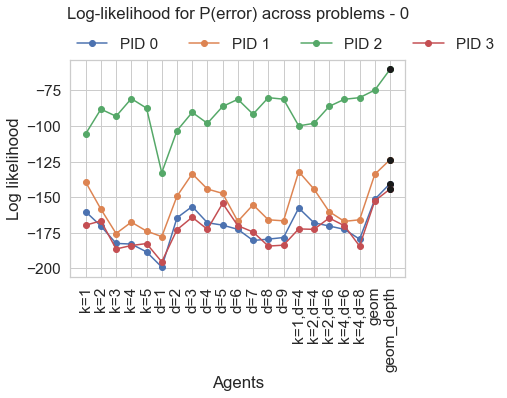

In [41]:
# parameter recovery

curr_df = fiveblock

sns.set_style("whitegrid")

agent_names_for_plot = agent_names + ['geom', 'geom_depth']

for pids in [
    sorted(curr_df.pid.unique()),

    # works with newer code
    #[name for name, _ in generating_agents[idx:idx+len(letters)]]
    #for idx in range(0, len(generating_agents), len(letters))
]:
    f, ax = plt.subplots()

    #names = [name for name, _ in agents]
    for pid in pids:
        i = model_inputs[pid]
        fits = _fit_models(arbitrary_problem, agent_names, i['model_p'], i['rand_p'])
        ll = [fits[name]['logp'] for name in agent_names_for_plot]
        #ll = [subject_p_err[pid, name]['logp'] for name in names]
        ax.plot(agent_names_for_plot, ll, '-o', label=f'PID {pid}')
        max_agent = np.argmax(ll)
        max_dot = ax.plot(agent_names_for_plot[max_agent], ll[max_agent], 'o', c='k')

    ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=4, 
                borderaxespad=0, frameon=False)

    ax.set_title(f'Log-likelihood for P(error) across problems - {list(pids)[0]}\n\n')
    ax.set_xlabel('Agents')
    ax.set_ylabel('Log likelihood')
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

In [40]:
# Comparing new model fits to old

for pid in curr_df.pid.unique():
    print('pid', pid)
    i = model_inputs[pid]
    fits = _fit_models(arbitrary_problem, agent_names, i['model_p'], i['rand_p'])
    print('\t', 'geom', fits['geom'])
    other_max_fit_k = max([k for k in fits.keys() if k != 'geom'], key=lambda k: fits[k]['logp'])
    print('\t', 'next best fit:', other_max_fit_k, fits[other_max_fit_k])

NameError: name 'curr_df' is not defined